In [1]:
using LinearAlgebra
using FFTW
using Random
using CairoMakie

In [2]:
# 2x2 Pauli X
function sigma_x()
    return [0 1; 1 0]
end
# 2x2 Pauli Y
function sigma_y()
    return [0 -im; im 0]
end
# 2x2 Pauli Z
function sigma_z()
    return [1 0; 0 -1]
end

sigma_z (generic function with 1 method)

<font size="12">HF Plots</font>

Phase competition between 2 phases:
- Symmetric phase
- Time-reversal breaking phase

The relevant Hamiltonian is $H = \hbar v_F (k_x \sigma^y - k_y \sigma^x) + \frac{\lambda _1}{k} \sigma^z$. 
- $\hbar v_F (k_x \sigma^y - k_y \sigma^x)$ is the Rashba SOC found on the surface of a 3D TI. This term acts as the kinetic energy.
- $\frac{\lambda _1}{k} \sigma^z$ is a mass term that gaps out the Dirac cone. This term breaks time-reversal symmetry.

In [3]:
alpha = 1 # fine-structure constant
epsilon = 1 # dielectric constant
c = 1 # speed of light
m = 0.0001 # Dirac mass
hbar = 1

1

In [4]:
# set momentum cutoffs
Lambda_down = 1
Lambda_up = 0

0

In [5]:
function rs_H0(alpha, epsilon, c, vF)
    return (3/4) * (alpha / epsilon) * (c / vF)
end

rs_H0 (generic function with 1 method)

In [6]:
# HF energy-density in ground state of Rashba Hamiltonian
function E_H0(alpha, epsilon, c, hbar, vF, L_up, L_down)
    return -hbar / (12 * pi * epsilon) * (c * alpha + 2 * epsilon * vF) * 
    (L_down^3 - L_up^3)
end

E_H0 (generic function with 1 method)

In [7]:
# HF energy-density in ground state of Rashba Hamiltonian + Dirac mass
function E_H1(alpha, epsilon, c, hbar, vF, m, L_up, L_down)
    return 1/(960 * pi * m^2 * epsilon) * 
    (-10 * alpha * hbar * c * m^2 * (L_up^3 + L_down^3) + 
    160 * epsilon * hbar * vF * m * (L_up^3 - L_down^3) - 
    alpha * c * hbar^3 * vF^2 * (L_up^5 + L_down^5) + 
    48 * epsilon * hbar^3 * vF^3 * (L_down^5 - L_up^5))
end

E_H1 (generic function with 1 method)

In [8]:
samps = 1000
vF_range = range(0, 0.035, samps)

0.0:3.503503503503503e-5:0.035

In [9]:
H0_energies = Array{Float64}(undef, samps)
H1_energies = Array{Float64}(undef, samps)
for i in 1:samps
    v_F = vF_range[i]
    H0_energies[i] = E_H0(alpha, epsilon, c, hbar, v_F, Lambda_up, Lambda_down)
    H1_energies[i] = E_H1(alpha, epsilon, c, hbar, v_F, m, Lambda_up, Lambda_down)
end

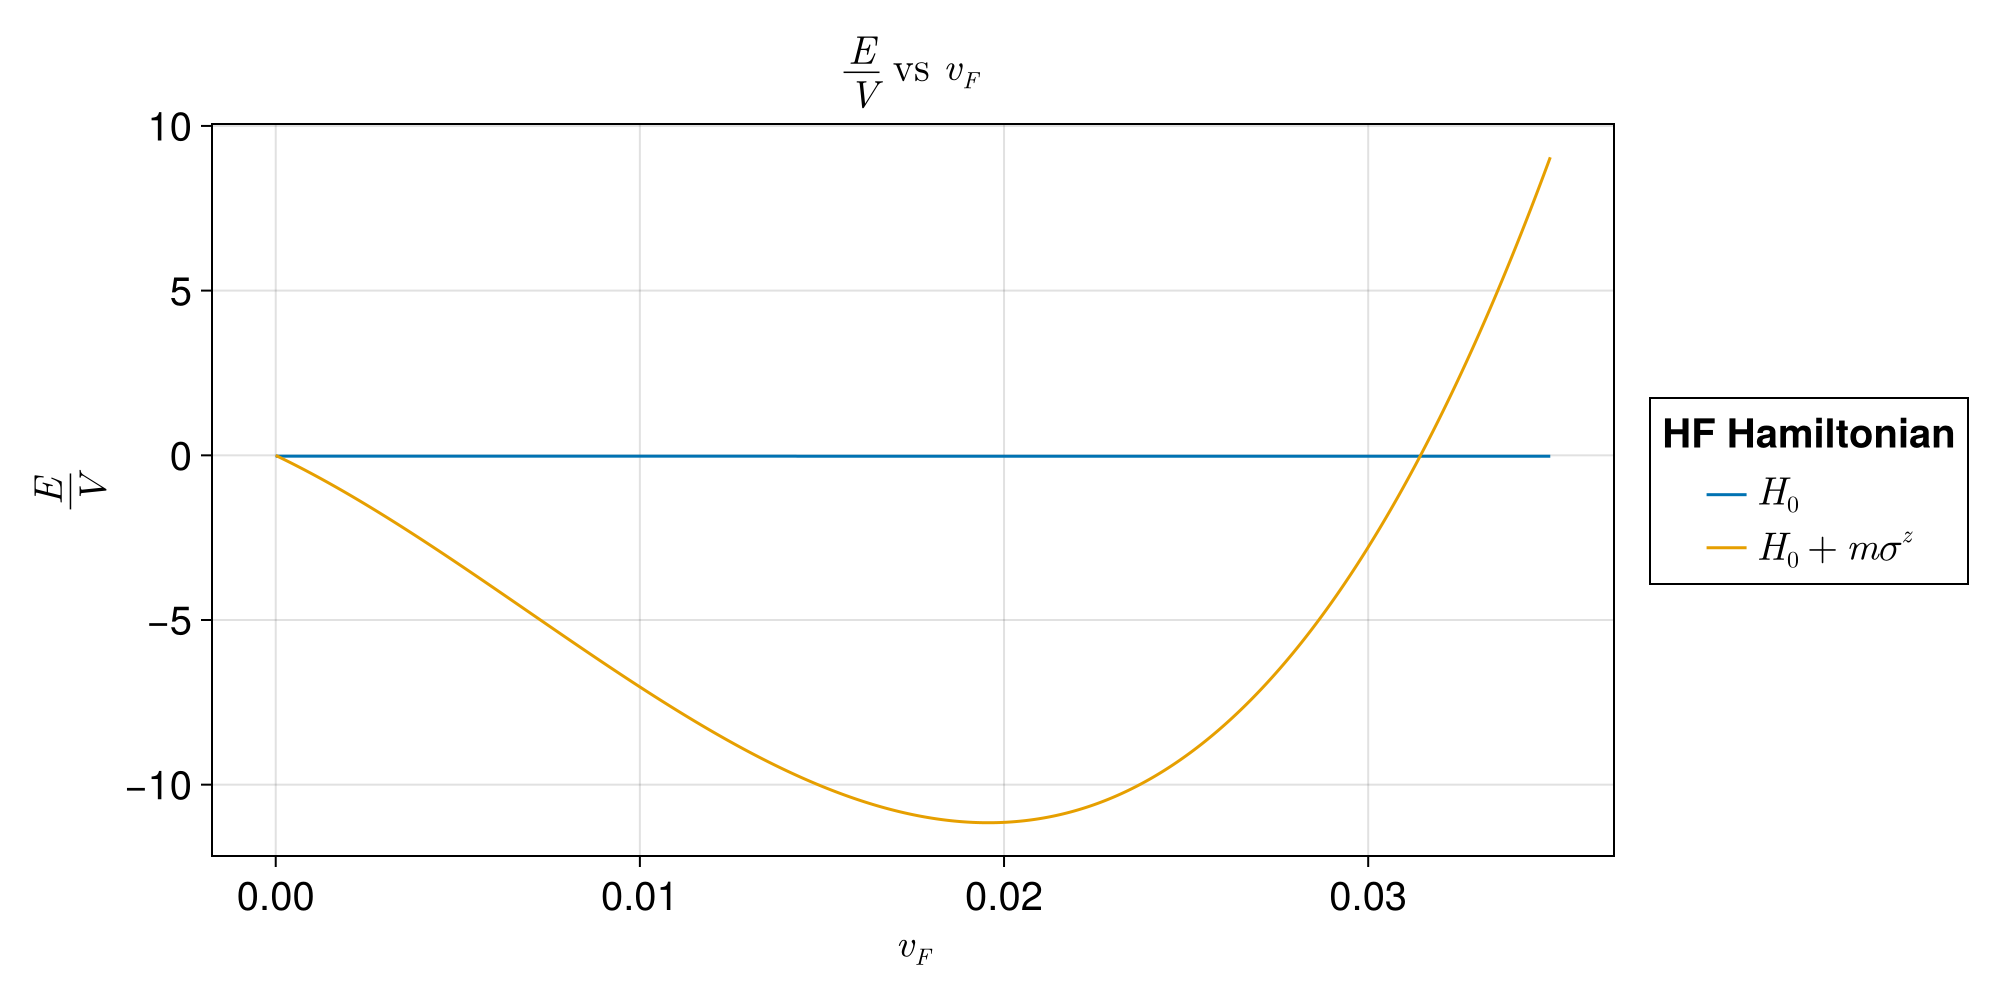

In [10]:
# create plot
P = Figure(size=(1000, 500), fontsize=20)
# create and configure axes
ax = Axis(P[1, 1], title = L"\frac{E}{V} \ \text{vs} \ v_F", xlabel = L"v_F", ylabel = L"\frac{E}{V}")
lines!(ax, vF_range, H0_energies, label = L"H_0")
lines!(ax, vF_range, H1_energies, label = L"H_0 + m \sigma^z")
# create and configure legend
P[1, 2] = Legend(P, ax, "HF Hamiltonian", framevisible = true)
P

<font size="12">3-Patch Plots</font>

In [11]:
# hartree energy
function E_hartree(l_gamma, C0, vF, hbar, a, m)
    if l_gamma == 1
        return (2/3)*(1 - (4*pi^2*hbar^2*vF^2)/(3*a^2*m^2))*cos(C0*2*pi/3) + 
        (2/3)*(4*pi^2*hbar^2*vF^2)/(3*sqrt(3)*a^2*m^2)*sin(C0*2*pi/3)
    end
    if l_gamma == -1
        return (2/3)*(-1/2)*cos(C0*2*pi/3) + 
        (2/3)*((8*pi^2*hbar^2*vF^2)/(3*sqrt(3)*a^2*m^2) - sqrt(3)/2)*
        sin(C0*2*pi/3)
    end
end

E_hartree (generic function with 1 method)

In [12]:
# fock energy
function E_fock(l_gamma, C0, vF, hbar, a, m)
    if l_gamma == 1
        return (-2/3)*(1 - (4*pi^2*hbar^2*vF^2)/(9*a^2*m^2))*cos(C0*2*pi/3) + 
        (2/3)*(4*pi^2*hbar^2*vF^2)/(3*sqrt(3)*a^2*m^2)*sin(C0*2*pi/3)
    end
    if l_gamma == -1
        return (-2/3)*(-1/2 + (8*pi^2*hbar^2*vF^2)/(9*a^2*m^2))*cos(C0*2*pi/3) +
        (2/3) * (sqrt(3)/2) * sin(C0*2*pi/3)
    end
end

E_fock (generic function with 1 method)

In [13]:
# 3-patch energy for non-trivial l-gamma
function E_patch(l_gamma, C0, vF, hbar, a, m, Vk, Vg)
    return Vg * E_hartree(l_gamma, C0, vF, hbar, a, m) + 
    Vk * E_fock(l_gamma, C0, vF, hbar, a, m)
end

E_patch (generic function with 1 method)

In [21]:
a = 1 # lattice constant
hbar = 1 
# interaction potential
Vk = 1
Vg = 1/sqrt(3)
m = 0.1 # Dirac mass

0.1

In [22]:
samps = 1000
vF_list = range(0, 0.04, samps)

0.0:4.004004004004004e-5:0.04

In [23]:
# energies (l_gamma, C0, samples)
energies = Array{Float64}(undef, 2, 3, samps)
for j in 1:2
    for c in 0:2
        for k in 1:samps
            gam = (-1)^j
            v = vF_list[k]
            energies[j, c + 1, k] = E_patch(gam, c, v, hbar, a, m, Vk, Vg)
        end
    end
end

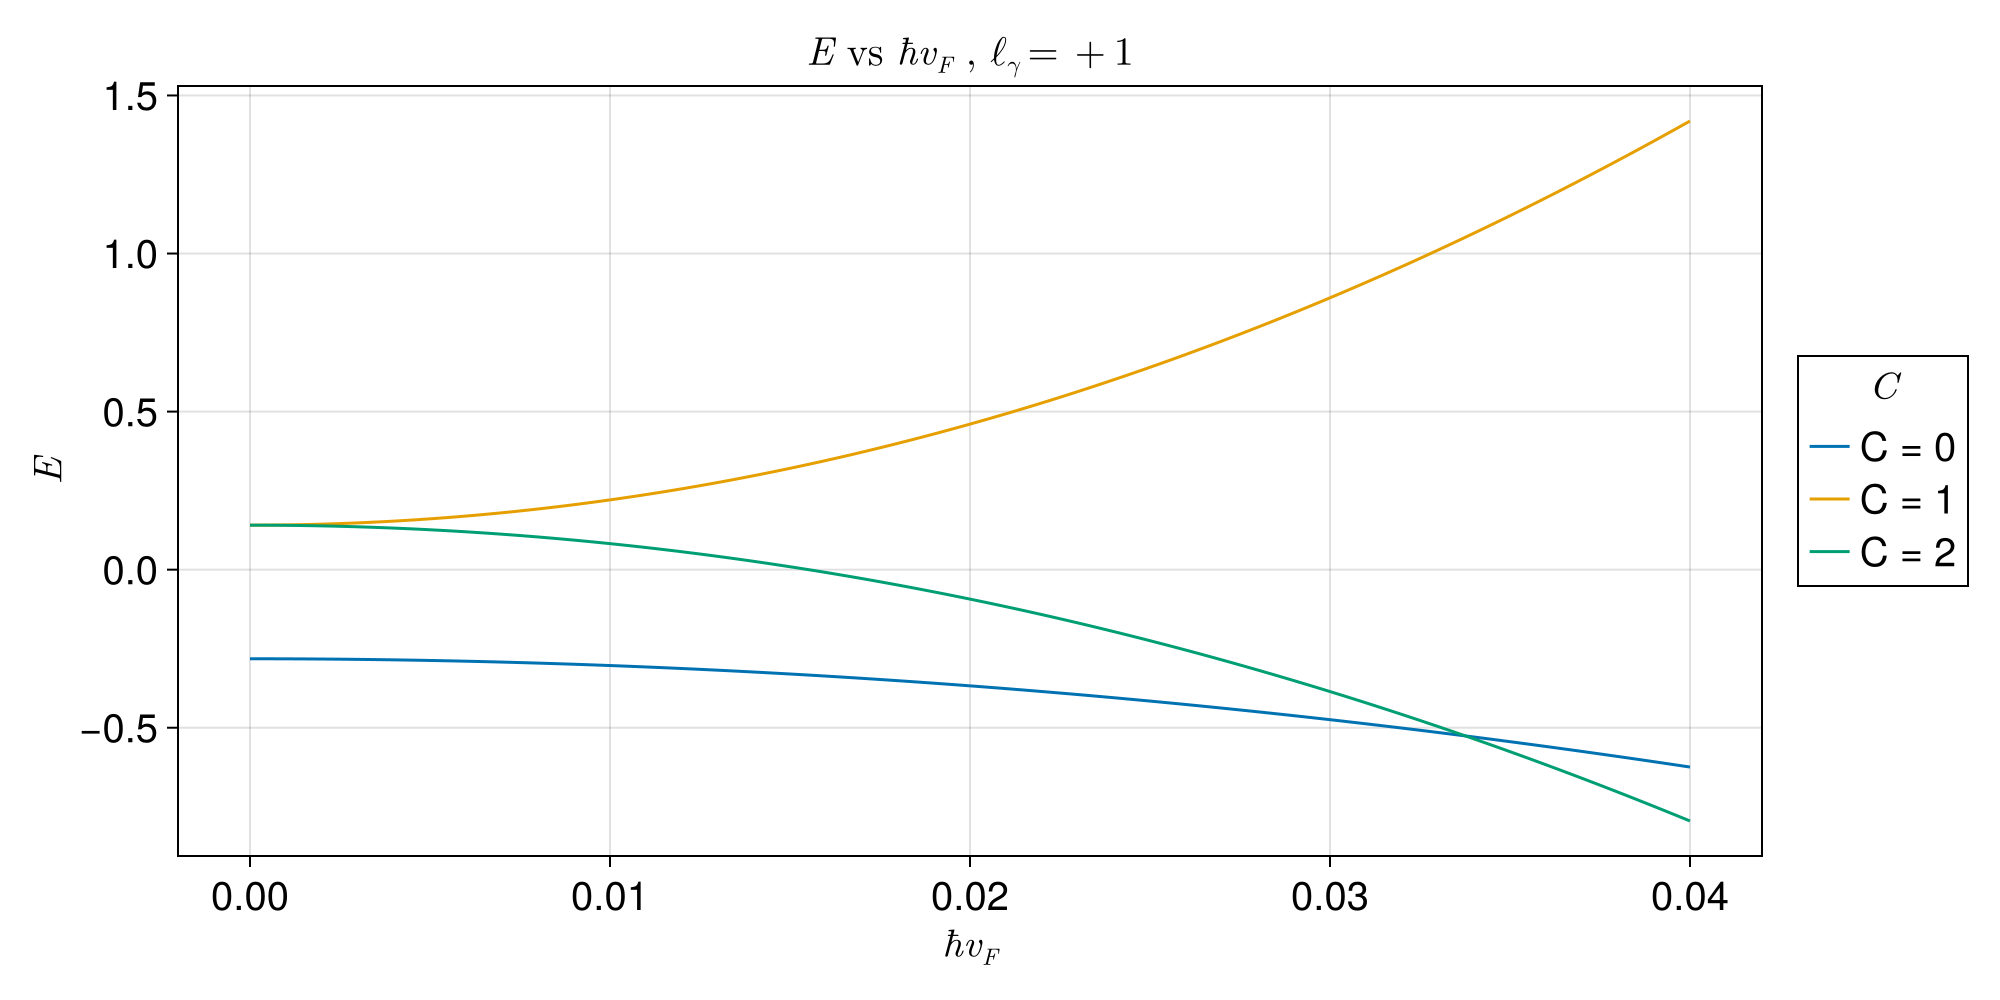

In [24]:
# Freeze into l_gamma = +1
l_gam = 1
P = Figure(size=(1000, 500), fontsize=20)
ax = Axis(P[1, 1], 
title = L"E \ \text{vs} \ \hbar v_F \ , \ \ell_\gamma = +1", 
xlabel = L"\hbar v_F", ylabel = L"E")
for i in 1:3
    lines!(ax, vF_list, energies[2, i, :], 
    label = "C = "*string(mod(i - 1 + l_gam + 2, 3)))
end
P[1, 2] = Legend(P, ax, L"C", 
framevisible = true)
P

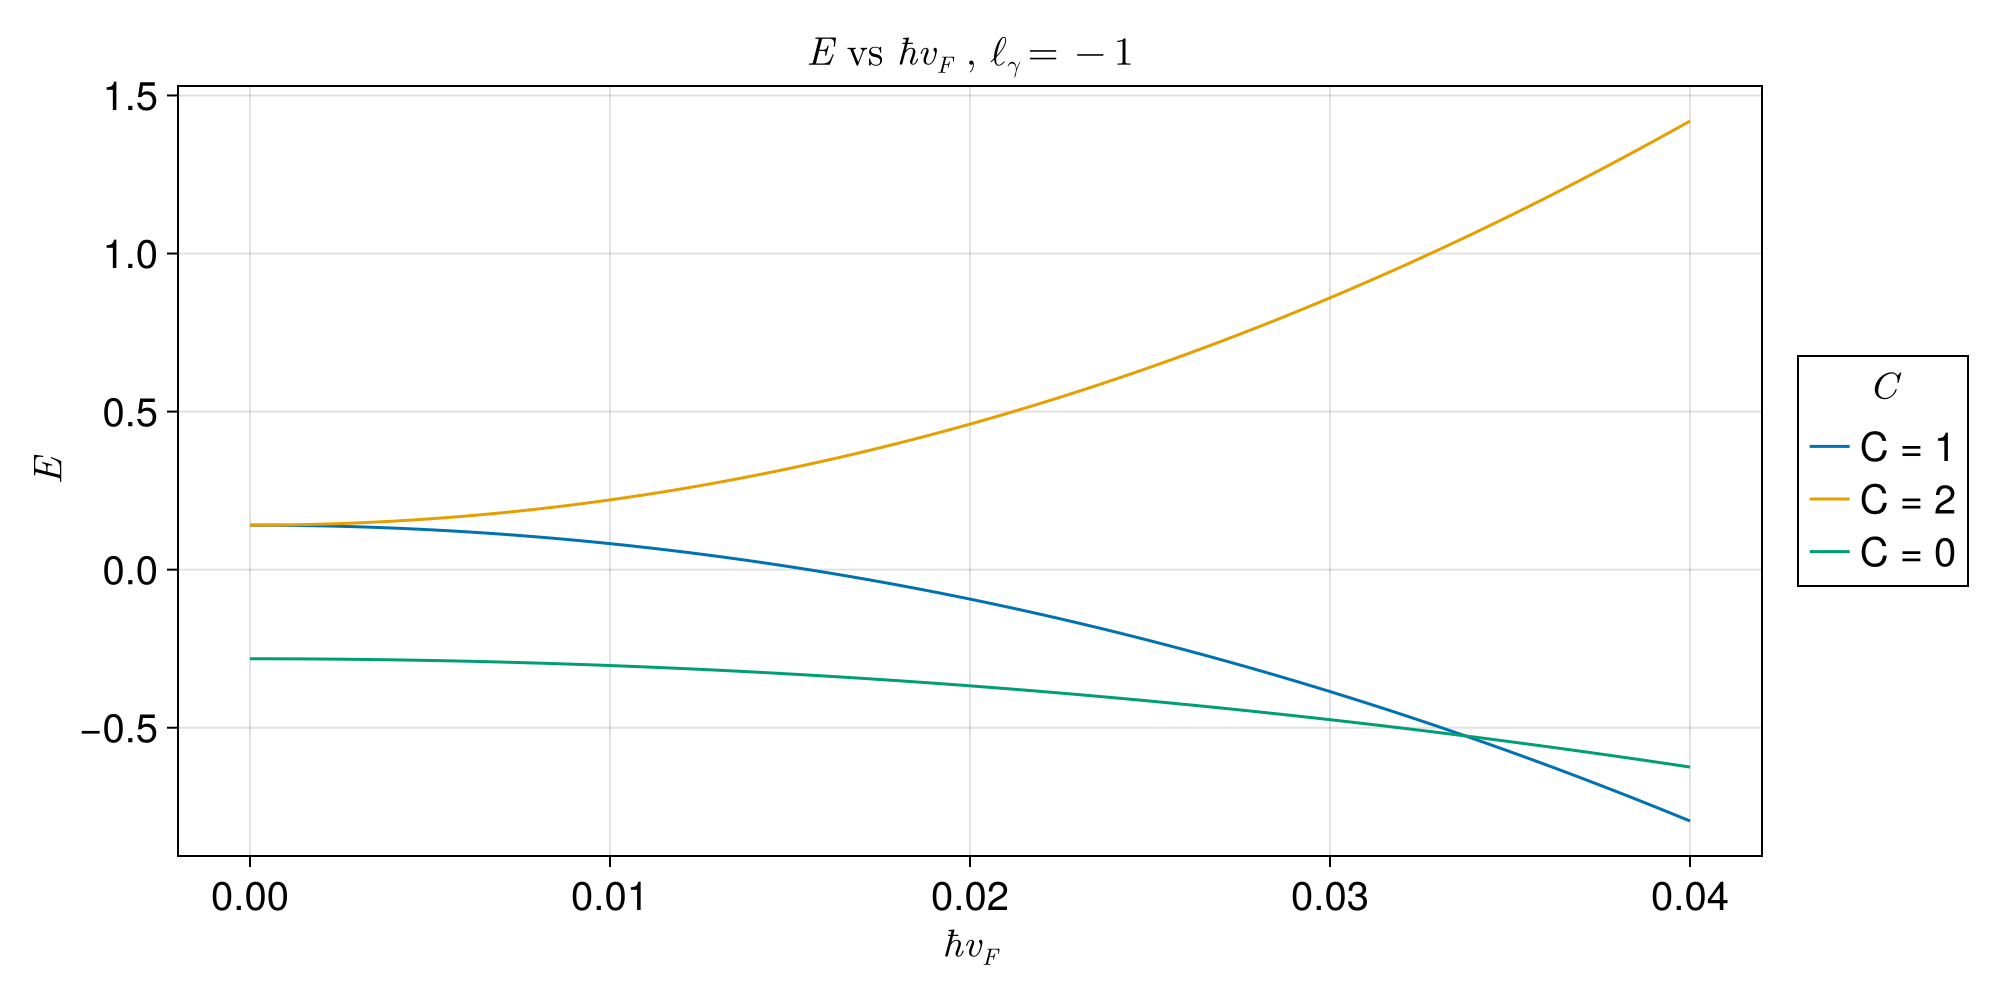

In [25]:
# Freeze into l_gamma = -1
l_gam = -1
P = Figure(size=(1000, 500), fontsize=20)
ax = Axis(P[1, 1], 
title = L"E \ \text{vs} \ \hbar v_F \ , \ \ell_\gamma = -1", 
xlabel = L"\hbar v_F", ylabel = L"E")
for i in 1:3
    lines!(ax, vF_list, energies[1, i, :], 
    label = "C = "*string(mod(i - 1 + l_gam + 2, 3)))
end
P[1, 2] = Legend(P, ax, L"C", 
framevisible = true)
P

Some commentary on the above plots.
- Note that for $\ell_\gamma = +1$, we see that there is a $C = 0$ dominated region. However, for sufficient $\hbar v_F$, we see that $C = -1$ becomes energetically favorable. 
- A similar analysis applies for $\ell_\gamma = -1$. Outisde of the small $C = 0$ favored region, we see that $C = +1$ dominates.
- The effect of switching the sign of $\ell_\gamma$ is switching the $C = +1$ and $C = -1$ bands. 

In [26]:
samps = 1000
vF_list = range(0, 0.04, samps)

0.0:4.004004004004004e-5:0.04

In [27]:
h_energies = Array{Float64}(undef, 2, 3, samps)
f_energies = Array{Float64}(undef, 2, 3, samps)
for j in 1:2
    for c in 0:2
        for k in 1:samps
            gam = (-1)^j
            v = vF_list[k]
            h_energies[j, c + 1, k] = E_hartree(gam, c, v, hbar, a, m)
            f_energies[j, c + 1, k] = E_fock(gam, c, v, hbar, a, m)
        end
    end
end

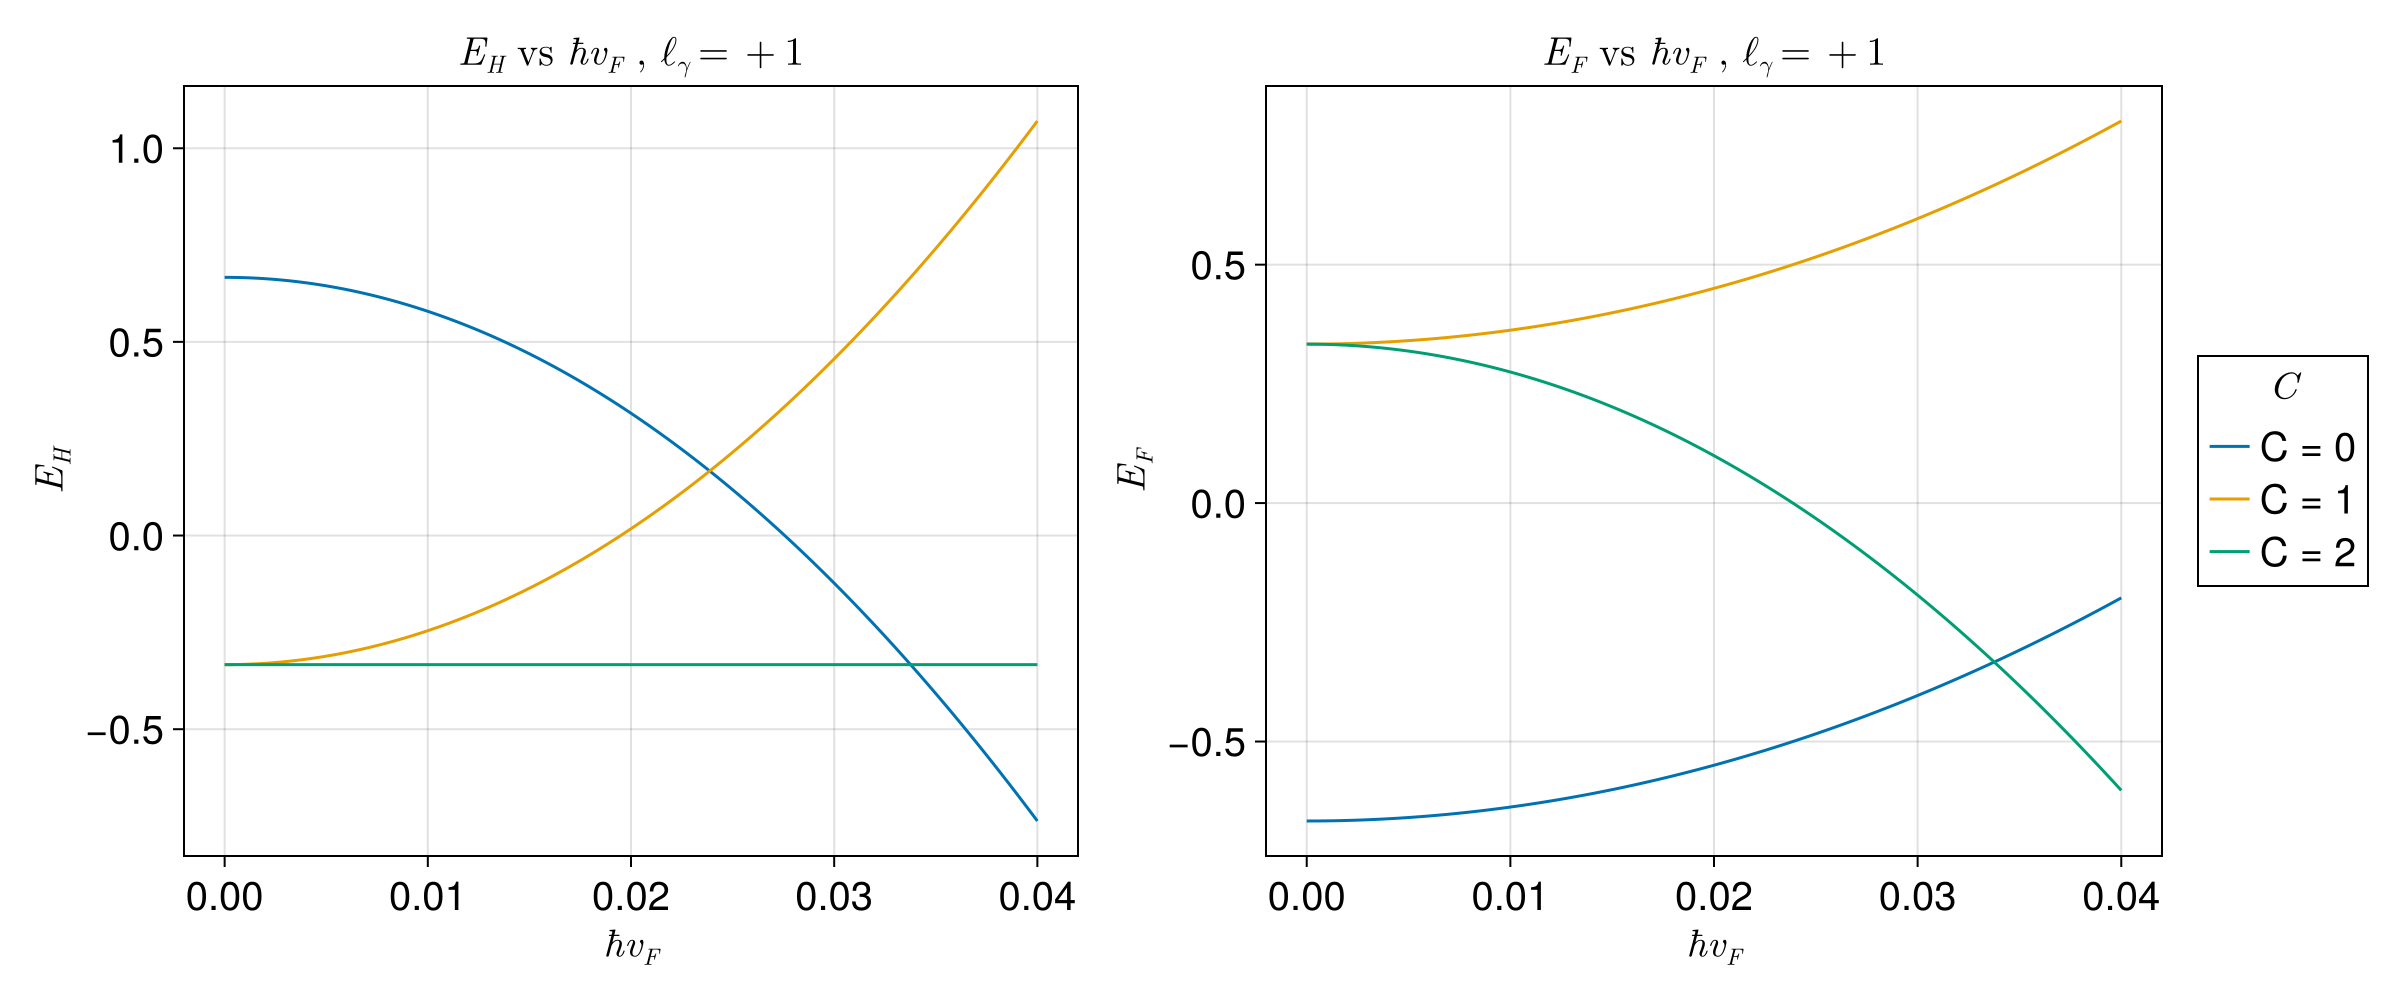

In [28]:
# Freeze into l_gamma = +1
l_gam = 1
P = Figure(size=(1200, 500), fontsize=20)
ax1 = Axis(P[1, 1], 
title = L"E_H \ \text{vs} \ \hbar v_F \ , \ \ell_\gamma = +1", 
xlabel = L"\hbar v_F", ylabel = L"E_H")
ax2 = Axis(P[1, 2], 
title = L"E_F \ \text{vs} \ \hbar v_F \ , \ \ell_\gamma = +1", 
xlabel = L"\hbar v_F", ylabel = L"E_F")
for i in 1:3
    lines!(ax1, vF_list, h_energies[2, i, :],
    label = "C = "*string(mod(i - 1 + l_gam + 2, 3)))
    lines!(ax2, vF_list, f_energies[2, i, :], 
    label = "C = "*string(mod(i - 1 + l_gam + 2, 3)))
end
P[1, 3] = Legend(P, ax1, L"C", 
framevisible = true)
P

We see that the Hartree energy favors $C = -1$ until the transition point (when it begins to favor $C = 0$). In contrast, the Fock energy favors $C = 0$ until the transition point (when it begins to favor $C = -1$). Note that the total energy is evidently Fock dominated, as the Fock phase diagram matches that of the total energy ($C = 0 \rightarrow C = -1$). 

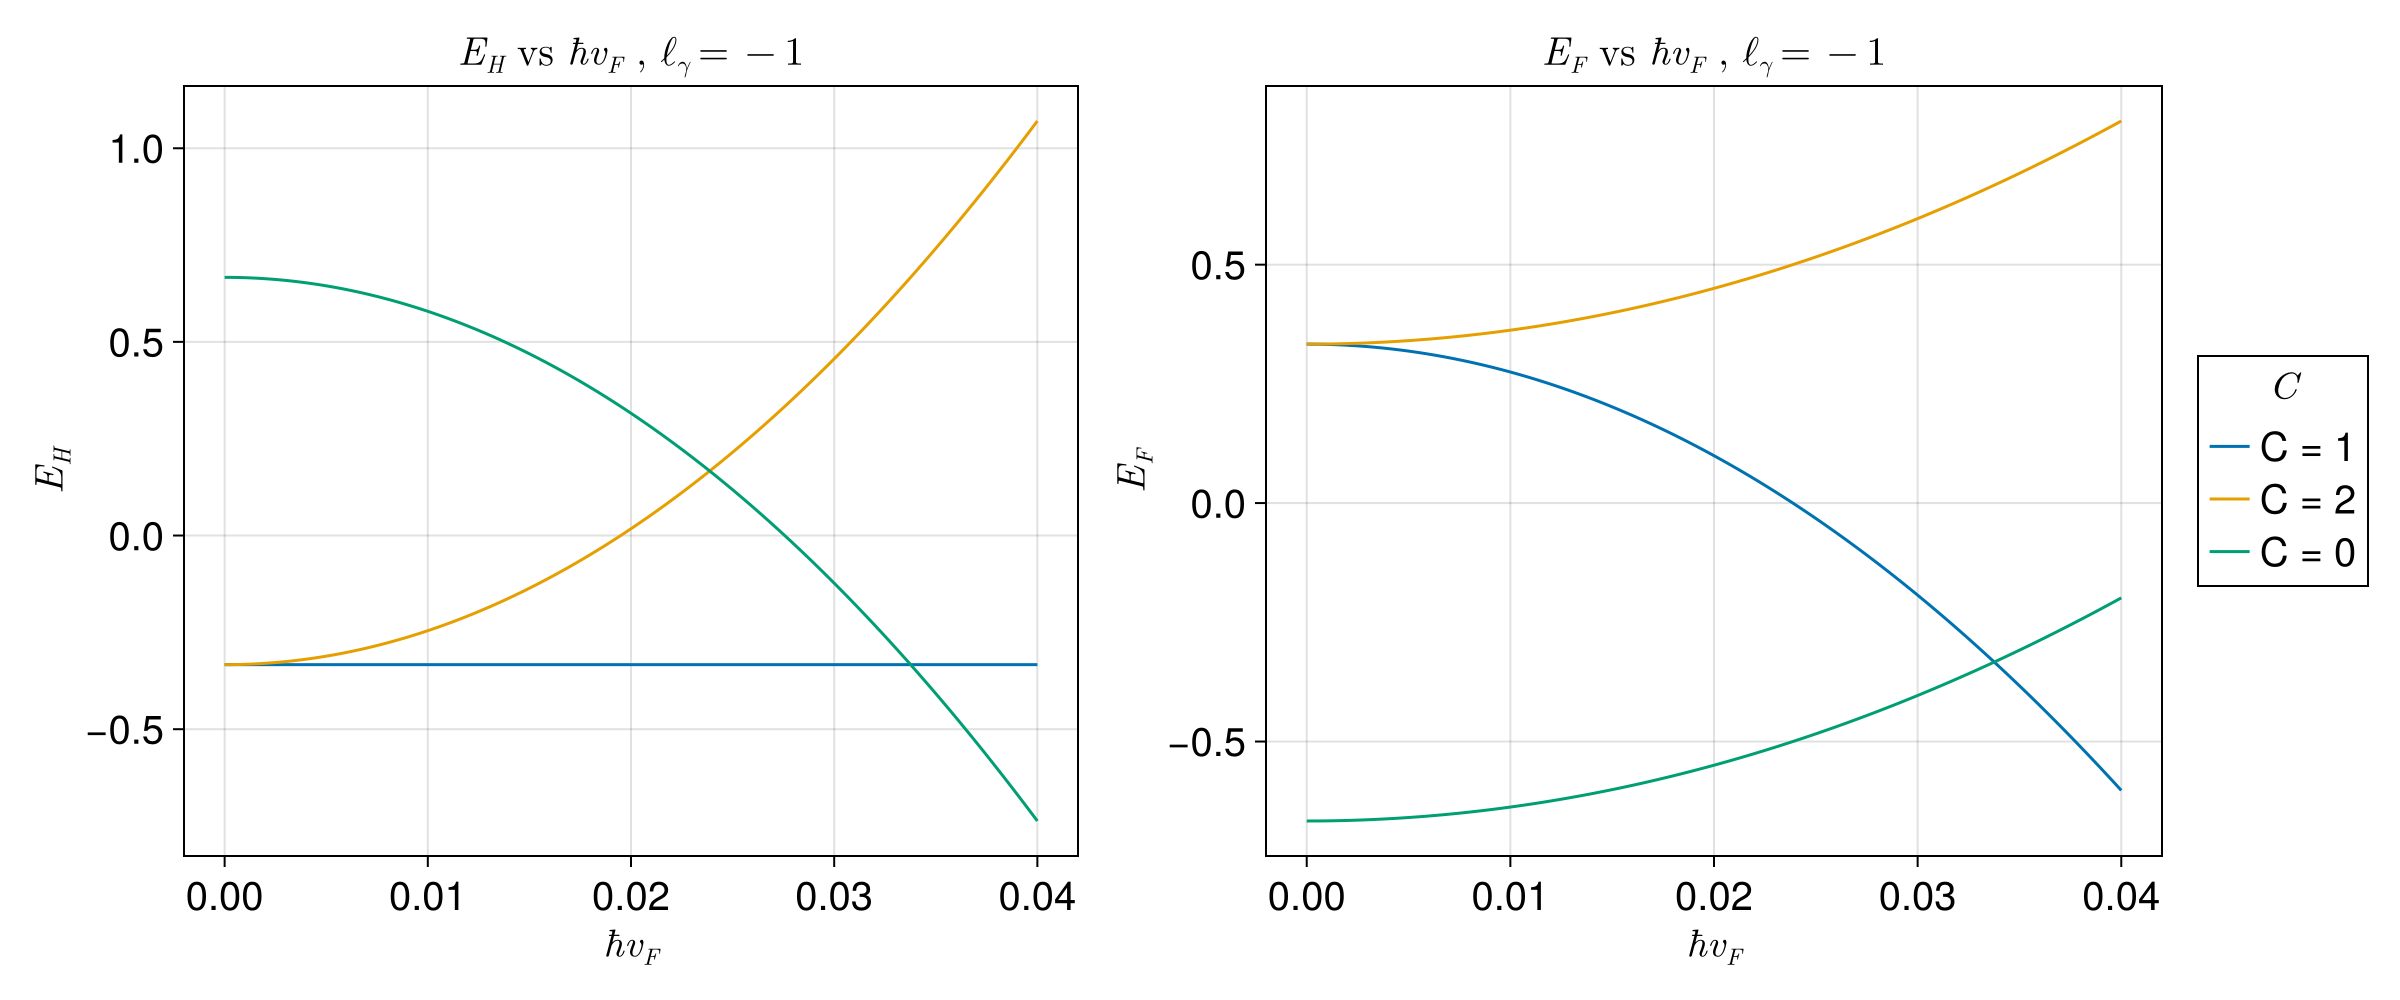

In [29]:
# Freeze into l_gamma = -1
l_gam = -1
P = Figure(size=(1200, 500), fontsize=20)
ax1 = Axis(P[1, 1], 
title = L"E_H \ \text{vs} \ \hbar v_F \ , \ \ell_\gamma = -1", 
xlabel = L"\hbar v_F", ylabel = L"E_H")
ax2 = Axis(P[1, 2], 
title = L"E_F \ \text{vs} \ \hbar v_F \ , \ \ell_\gamma = -1", 
xlabel = L"\hbar v_F", ylabel = L"E_F")
for i in 1:3
    lines!(ax1, vF_list, h_energies[1, i, :], 
    label = "C = "*string(mod(i - 1 + l_gam + 2, 3)))
    lines!(ax2, vF_list, f_energies[1, i, :], 
    label = "C = "*string(mod(i - 1 + l_gam + 2, 3)))
end
P[1, 3] = Legend(P, ax1, L"C", 
framevisible = true)
P

We see that the Hartree energy favors $C = +1$ until the transition point (when it begins to favor $C = 0$). In contrast, the Fock energy favors $C = 0$ until the transition point (when it begins to favor $C = +1$). Note that the total energy is evidently Fock dominated, as the Fock phase diagram matches that of the total energy ($C = 0 \rightarrow C = +1$). 